Teste de otimizacao dos parametros cineticos usando o algoritmo de levenberg-marquardt (LM)


Bibliotecas

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn as skl
from sklearn.metrics import root_mean_squared_error as rmse_score
from sklearn.metrics import r2_score

import scipy as scipy
from scipy.integrate import odeint
from scipy.optimize import least_squares

Funcoes usadas no programa

In [11]:
## Definicao das edos da  cinetica do microrganismo

# Função das equações diferenciais
def f_flow_opt(y, x, param):
    # Glicose, Acido Acetico, Acido Butirico, Acetona, Butanol, Etanol, Biomassa
    G, P, X = y
    Vmax_X, Ks, Kp, Kd, alpha, Y_XS, Y_PS = param[0],param[1],param[2],param[3],param[4],param[5],param[6]

    mi =  Vmax_X*(G/(Ks+G))*((1-(P/Kp))**alpha)-Kd

    dGdt = -mi*X*(1/Y_XS)
    dXdt = X*mi
    dBdt = X*mi*(Y_PS/Y_XS)

    return np.array([dGdt, dBdt, dXdt])

In [12]:
### Calculo dos parametros de erro
def func_residuo(param, x, x_exp, y_exp, y_ini):

    #print("tipo de param em func_residuo:",type(param))
    #print("param em func_residuo:",param)
    # Extrai os parâmetros
    Vmax_X, Ks, Kp, Kd, alpha, Y_XS, Y_PS = param[0],param[1],param[2],param[3],param[4],param[5],param[6]

    # Integra as EDOs com os parâmetros atuais
    #solucao_modelo = odeint(modelo_sir, y0_inicial, tempo, args=(param))
    y_predicted = odeint(f_flow_opt, y_ini, x, args=(param,))
    # Conversão para arrays numpy
    #x = np.array(x)
    #print("y_predicted_head em func_residuo:",y_predicted[1:5,0])
    n_pontos = len(x_exp)
    yG_pred = [0]*n_pontos  # glicose
    yP_pred = [0]*n_pontos # Butanol
    yX_pred = [0]*n_pontos # Biomassa

    # Glicose, Acido Acetico, Acido Butirico, Acetona, Butanol, Etanol, Biomassa
    cont = 0;
    ind = 0
    while cont<n_pontos:
      if round(x[ind],4)==x_exp[cont]:
        yG_pred[cont] = np.array(y_predicted[ind,0]) # Glicose
        yP_pred[cont] = np.array(y_predicted[ind,1]) # Butanol
        yX_pred[cont] = np.array(y_predicted[ind,2])-y_ini[2] # Biomassa
        cont=cont+1
      ind=ind+1

    # Calcula os resíduos para cada variável e os concatena
    # É crucial que o array de resíduos seja 1D para least_squares
    resid_yG = y_exp[0,:] - yG_pred
    resid_yP = y_exp[1,:]- yP_pred
    resid_yX = (y_exp[2,:]- yX_pred)*5

    # Retorna um único array 1D com todos os resíduos
    resid = np.concatenate((resid_yG,resid_yP, resid_yX))
    return resid

In [13]:
# Calcular os parametros de erro R2 e RMSE
def func_crit_erro (x_exp, y_exp,x, y_predicted):

  n_pontos = len(x_exp)
  yG_pred = [0]*n_pontos  # glicose
  yP_pred = [0]*n_pontos # Butanol
  yX_pred = [0]*n_pontos # Biomassa

  cont = 0;
  ind = 0
  while cont<n_pontos:
    if round(x[ind],4)==x_exp[cont]:
      yG_pred[cont] = np.array(y_predicted[ind,0]) # Glicose
      yP_pred[cont] = np.array(y_predicted[ind,1]) # Butanol
      yX_pred[cont] = np.array(y_predicted[ind,2])-y_ini[2] # Biomassa
      cont=cont+1
    ind=ind+1
  #print("tipo de y_exp:",y_exp[0,:])
  rmse_y1 = rmse_score(y_exp[0,:],yG_pred)
  r2_y1 = r2_score(y_exp[0,:],yG_pred)

  rmse_y11 = rmse_score(y_exp[1,:],yP_pred)
  r2_y11 = r2_score(y_exp[1,:],yP_pred)

  rmse_y13 = rmse_score(y_exp[2,:],yX_pred)
  r2_y13 = r2_score(y_exp[2,:],yX_pred)

  #r2_comp = np.concatenate((r2_y1,r2_y8, r2_y9,r2_y10,r2_y11, r2_y13))
  #rmse_comp = np.concatenate((rmse_y1,rmse_y8, rmse_y9,rmse_y10,rmse_y11, rmse_y13))
  r2_comp = (r2_y1,r2_y11, r2_y13)
  rmse_comp = (rmse_y1,rmse_y11, rmse_y13)
  return r2_comp,rmse_comp

Definicao dos dados experimentos e dos artigos usados na comparacao

In [14]:
address = "/content/drive/MyDrive/_Doutorado/Tese_Bruno Ferreira_LOPCA Ferm/Congressos/IConBM2026 (Em preparo)/modelos/Ferm_results.xlsx"

In [15]:
#dados = pd.read_excel(address,sheet_name="PVC01")
dados = pd.read_excel(address,sheet_name="01")
#print(dados)
dados=np.array(dados)
#0-"Time (h)"/1-"Glucose"/2-"Xylose"/3-"Glycerol"/4-"Acetic acid"/5-"1,3-PDO"/6-"Ethanol"/7-"Butyric acid"/8-"Acetone"/9-"Butanol"/10-"ABE"/11-"DO"/12-"X"

In [16]:
experimental_data = {
    'time': dados[:,0],
    'glucose': dados[:,1],
    'xylose': dados[:,2],
    'acetic acid': dados[:,4],
    'ethanol': dados[:,6],
    'butyric acid': dados[:,7],
    'butanol': dados[:,9],
    'ABE': dados[:,10],
    'biomass': dados[:,12],
}

Valores de chute inicial para a otimizacao

In [17]:
# intervalo de tempo da simulacao
h = 0.001
x=np.arange(0.0, 96.0+h, h)

param_ini=[7.00e-01, 4.91745023e+01, 7.50000000e+00, 1.00000000e-05,
 1.70000000e+00, 7.13317405e-02, 1.94649613e-01]
param_ini=np.array(param_ini)

lista_param_ID = ["Vmax_X","Ks","Kp","Kd","alpha","Y_XS","Y_PS"]

#### valores inicias das substancias (1 para cada EDO)
y_ini=np.array([experimental_data['glucose'][0],experimental_data['butanol'][0],experimental_data['biomass'][0]])

#extracao dos dados experimentais para serem passados as funcoes
y_exp=np.array([experimental_data['glucose'],experimental_data['butanol'],experimental_data['biomass']])
x_exp=np.array(experimental_data['time'])

Otimizacao dos parametros das EDOs

In [23]:
#print("param otm:", param_optm)
#bd_inf = [0.1,30,2,0.01,0.1,0.05,0.20]
bd_inf = [0.1,5,7.5,0.00001,0.10,0.06,0.18]
bd_sup = [0.7,60,15,0.10,1.7,0.1,0.23]

resultado = least_squares(func_residuo, param_ini,args=(x, x_exp, y_exp, y_ini), bounds=(bd_inf, bd_sup)) # 'lm' para Levenberg-Marquardt
param_optm = resultado.x
print("param init:", param_ini)
print("param optm:", param_optm)

param init: [7.00000000e-01 4.91745023e+01 7.50000000e+00 1.00000000e-05
 1.70000000e+00 7.13317405e-02 1.94649613e-01]
param optm: [7.00000000e-01 4.91744407e+01 7.50000000e+00 1.00000000e-05
 1.70000000e+00 7.13317547e-02 1.94649640e-01]


In [22]:
print("Comparizon between the initial and optimized parameters values:\n")
for i in range(len(param_ini)):
  diff = param_ini[i] - param_optm[i]
  perc_dif = diff/param_ini[i]*100
  print("Initial: ", param_ini[i], " - Optimized: ",round(param_optm[i],4),
        " - Diff: ",round(diff,4)," - % dif: ",round(perc_dif,2)," %",
        " - Parameter ID ", lista_param_ID[i])

Comparizon between the initial and optimized parameters values:

Initial:  0.7  - Optimized:  0.7  - Diff:  0.0  - % dif:  0.0  %  - Parameter ID  Vmax_X
Initial:  49.1745023  - Optimized:  49.1744  - Diff:  0.0001  - % dif:  0.0  %  - Parameter ID  Ks
Initial:  7.5  - Optimized:  7.5  - Diff:  -0.0  - % dif:  -0.0  %  - Parameter ID  Kp
Initial:  1e-05  - Optimized:  0.0  - Diff:  -0.0  - % dif:  -0.0  %  - Parameter ID  Kd
Initial:  1.7  - Optimized:  1.7  - Diff:  0.0  - % dif:  0.0  %  - Parameter ID  alpha
Initial:  0.0713317405  - Optimized:  0.0713  - Diff:  -0.0  - % dif:  -0.0  %  - Parameter ID  Y_XS
Initial:  0.194649613  - Optimized:  0.1946  - Diff:  -0.0  - % dif:  -0.0  %  - Parameter ID  Y_PS


Calculo dos criterios de erro para os modelos com os parametros otimizados

In [20]:
y_pred_art = odeint(f_flow_opt, y_ini, x, args=(param_ini,))

r2_a,rmse_a = func_crit_erro (x_exp, y_exp,x, y_pred_art)
print("\nPerformance criteria results for the initial guess:")
print("\nparam:", param_ini)
print("\033[1mR2\033[0m","\nGlucose:", r2_a[0],"\nButanol:", r2_a[1],"\nBiomass:", r2_a[2])
print("\033[1mRMSE\033[0m","\nGlucose:", rmse_a[0],"\nButanol:", rmse_a[1],"\nBiomass:", rmse_a[2],)

#param_optm=param_ini
y_pred_otm = odeint(f_flow_opt, y_ini, x, args=(param_optm,))
r2,rmse = func_crit_erro (x_exp, y_exp,x, y_pred_otm)
print("\nPerformance criteria results for the optimized parameters:")
print("\nparam:", param_optm)
print("\033[1mR2\033[0m","\nGlucose:", r2[0],"\nButanol:", r2[1],"\nBiomass:", r2[2])
print("\033[1mRMSE\033[0m","\nGlucose:", rmse[0],"\nButanol:", rmse[1],"\nBiomass:", rmse[2])

#print(y_pred_art-y_pred_otm)


Performance criteria results for the initial guess:

param: [7.00000000e-01 4.91745023e+01 7.50000000e+00 1.00000000e-05
 1.70000000e+00 7.13317405e-02 1.94649613e-01]
R2 
Glucose: 0.9840707191499882 
Butanol: 0.8111011906883743 
Biomass: 0.796640380557013
RMSE 
Glucose: 2.0693068458122177 
Butanol: 1.4883028137109013 
Biomass: 0.4700295938240282

Performance criteria results for the optimized parameters:

param: [7.00000000e-01 4.91744407e+01 7.50000000e+00 1.00000000e-05
 1.70000000e+00 7.13317547e-02 1.94649640e-01]
R2 
Glucose: 0.9840707107290504 
Butanol: 0.8111009383500156 
Biomass: 0.7966405728511272
RMSE 
Glucose: 2.069307392776714 
Butanol: 1.4883038077768913 
Biomass: 0.4700293715971525


Graficos comparando os dados exp, e os modelos do artigo e otimizado

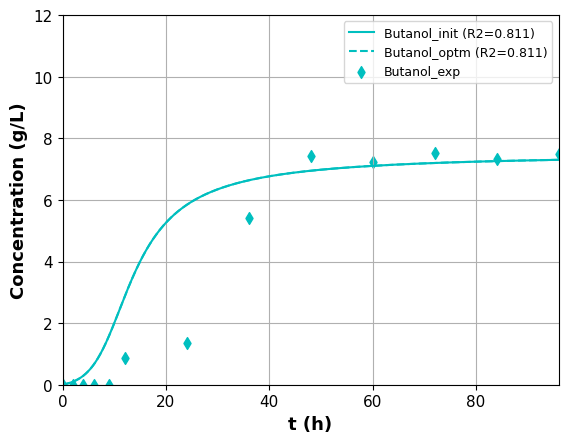

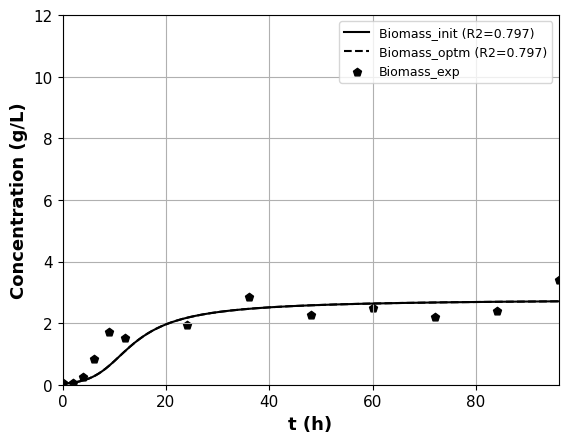

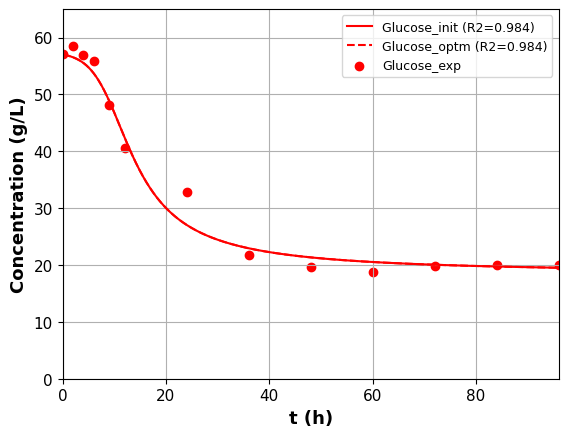

In [21]:
# Gráficos dos fluxos molares

fz_labels = 13
fz_title = 15
fz_ticks = 11
fz_lgd = 9

plt.figure()
plt.plot(x, y_pred_art[:,1], label='Butanol_init (R2='+str(round(r2_a[1],3))+")",color='c', linestyle='-')
plt.plot(x, y_pred_otm[:,1], label='Butanol_optm (R2='+str(round(r2[1],3))+")",color='c', linestyle='--')
plt.scatter(x_exp, y_exp[1,:],label='Butanol_exp',color='c', marker='d')
plt.xlabel('t (h)',fontweight='bold', fontsize=fz_labels)
plt.ylabel('Concentration (g/L)',fontweight='bold', fontsize=fz_labels)
#plt.title('Concentração dos produtos durante a fermentação')
plt.tick_params(labelsize=fz_ticks)
plt.tick_params(labelsize=fz_ticks)
plt.xlim([0,96.])
plt.ylim([0,12.])
plt.legend(bbox_to_anchor=(1., 1.), fontsize=fz_lgd)
plt.grid()

plt.figure()
plt.plot(x, y_pred_art[:,2], label='Biomass_init (R2='+str(round(r2_a[2],3))+")",color='k', linestyle='-')
plt.plot(x, y_pred_otm[:,2], label='Biomass_optm (R2='+str(round(r2[2],3))+")",color='k', linestyle='--')
plt.scatter(x_exp, y_exp[2,:]+y_ini[2],label='Biomass_exp', color='k', marker='p')
plt.xlabel('t (h)',fontweight='bold', fontsize=fz_labels)
plt.ylabel('Concentration (g/L)',fontweight='bold', fontsize=fz_labels)
#plt.title('Concentração dos produtos durante a fermentação')
plt.tick_params(labelsize=fz_ticks)
plt.tick_params(labelsize=fz_ticks)
plt.xlim([0,96.])
plt.ylim([0,12.])
plt.legend(fontsize=fz_lgd)
plt.grid()

plt.figure()
plt.plot(x, y_pred_art[:,0], label='Glucose_init (R2='+str(round(r2_a[0],3))+")",color='red', linestyle='-')
plt.plot(x, y_pred_otm[:,0], label='Glucose_optm (R2='+str(round(r2[0],3))+")",color='red', linestyle='--')
plt.scatter(x_exp, y_exp[0,:],label='Glucose_exp',color='red', marker='o')
plt.xlabel('t (h)',fontweight='bold', fontsize=fz_labels)
plt.ylabel('Concentration (g/L)',fontweight='bold', fontsize=fz_labels)
#plt.title('Concentração dos produtos durante a fermentação')
plt.tick_params(labelsize=fz_ticks)
plt.tick_params(labelsize=fz_ticks)
plt.xlim([0,96.])
plt.ylim([0,65.])
plt.legend(fontsize=fz_lgd)
plt.grid()

plt.show()